# Yeast cells detection evaluation notebook

In [7]:
import sys
sys.path.append('/home/p301081/yeastcells-detection-maskrcnn') # add repository path
#sys.path.append('') #insert local path to detecron2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yeastcells.clustering as clustering
import yeastcells.features as features
import yeastcells.data as data
import yeastcells.model as model
import yeastcells.visualize as visualize
import yeastcells.evaluation as evaluation

%matplotlib notebook

In [8]:
cd ~

/home/p301081


### Load data

In [9]:
TS = 'TestSet1' #choose YIT test set
path = f'../../slow-data/yeastcells/data/cellstar_benchmark/{TS}'
filenames = data.load_data(path, ff='.tif')

In [10]:
image = data.read_images_cat(filenames)
np.shape(image)

(60, 512, 512, 3)

### Load and run model on data for segmentation

In [11]:
seg_path = f'{path}/GroundTruth_Segmentation.csv'
track_path = f'{path}/GroundTruth_Tracking.csv'
gt_s, gt_t = data.get_gt_yit(seg_path, track_path)

#set path to model_final.pth
model_path = '/var/tensorflow-logs/p253591/yeast-cell-detection-run-4'

### Segmentation threshold score hyperparameter tuning

In [ ]:
precision_s = []
recall_s = []
accuracy_s = []
F_s = []
precision_t = []
recall_t = []
accuracy_t = []
F_t = []

sts = [0.8,.81,.82,.83,.84,.85,.86,.87,.88,.89,.9,.91,.92,.93,.94,.95,.96,.97,.98,.99]

for i in range(len(sts)):
#load model
    predictor = model.load_model(model_path, seg_thresh=sts[i], device='cuda:0') #set GPU if available otherwise use 'cpu'

    output = [
      {'instances': predictor(frame)['instances'].to('cpu')}
      for frame in image
    ]

    labels, coordinates = clustering.cluster_cells(output, dmax=5, min_samples=3, eps=0.6, progress=False)

    pred_s, pred_t, _ = data.get_pred(output, labels, coordinates)

    results_s = evaluation.get_seg_performance(pred_s, gt_s, output, pipeline='maskrcnn') 
    results_t = evaluation.get_track_performance(pred_t, gt_t, output, pipeline='maskrcnn')

    metrics_s = evaluation.calculate_metrics(results_s, pred_s, gt_s)
    metrics_t = evaluation.calculate_metrics(results_t, pred_t, gt_t)
    
    precision_s.append(metrics_s['Precision'])
    recall_s.append(metrics_s['Recall'])
    accuracy_s.append(metrics_s['Accuracy'])
    F_s.append(metrics_s['F1-score'])
    precision_t.append(metrics_t['Precision'])
    recall_t.append(metrics_t['Recall'])
    accuracy_t.append(metrics_t['Accuracy'])
    F_t.append(metrics_t['F1-score'])

<IPython.core.display.Javascript object>


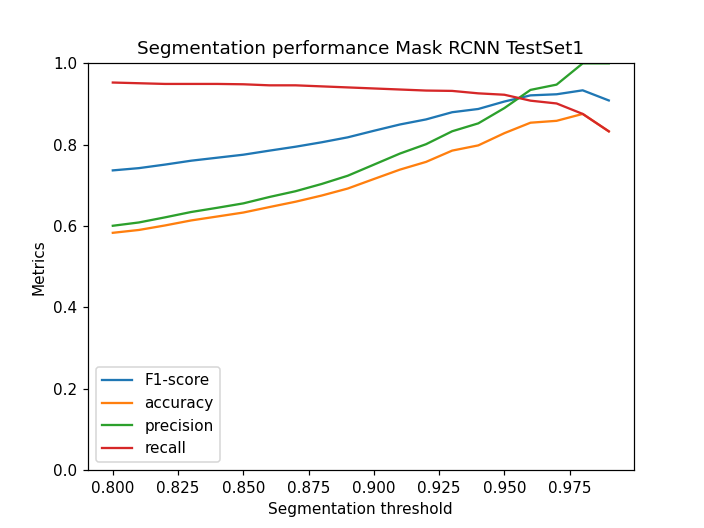

In [20]:
plt.figure()
plt.title(f'Segmentation performance Mask RCNN {TS}')
plt.xlabel('Segmentation threshold')
plt.ylabel('Metrics')
plt.plot(sts, F_s, label='F1-score')
plt.plot(sts, accuracy_s, label='accuracy')
plt.plot(sts, precision_s, label='precision')
plt.plot(sts, recall_s, label='recall')
plt.ylim(0,1)
plt.legend()

### Rerun pipeline with optimized sts before tuning tracking

In [15]:
predictor = model.load_model(model_path, seg_thresh=0.955, device='cuda:0') #set GPU if available otherwise use 'cpu'
output = [
      {'instances': predictor(frame)['instances'].to('cpu')}
      for frame in image
    ]
labels, coordinates = clustering.cluster_cells(output, dmax=5, min_samples=3, eps=0.6, progress=False)
pred_s, pred_t, _ = data.get_pred(output, labels, coordinates)
results_s = evaluation.get_seg_performance(pred_s, gt_s, output, pipeline='maskrcnn') 
results_t = evaluation.get_track_performance(pred_t, gt_t, output, pipeline='maskrcnn')
metrics_s = evaluation.calculate_metrics(results_s, pred_s, gt_s)
metrics_t = evaluation.calculate_metrics(results_t, pred_t, gt_t) 

/home/p301081/.virtualenvs/yeastcells/lib/python3.7/site-packages/sklearn/neighbors/_base.py:168: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  EfficiencyWarning)


In [16]:
print("%.4f" % metrics_s['Precision'])
print("%.4f" % metrics_s['Recall'])
print("%.4f" % metrics_s['Accuracy'])
print("%.4f" % metrics_s['F1-score'])
print("%.4f" % metrics_t['Precision'])
print("%.4f" % metrics_t['Recall'])
print("%.4f" % metrics_t['Accuracy'])
print("%.4f" % metrics_t['F1-score'])

0.9137
0.9168
0.8437
0.9152
0.9159
0.9183
0.8470
0.9171


### Dmax and epsilon hyperparameter tuning for tracking evaluation

In [17]:
param_grid = {
    'dmax': list(np.arange(2, 7, 1)),
    'eps': list(np.around(np.arange(0.35, 0.91, 0.05), decimals=2)),
}
n_compare = len(param_grid['dmax'])*len(param_grid['eps'])
n_compare

60

In [ ]:
precision = []
recall = []
accuracy = []
F1 = []

dbscan_params = []

for dmax in param_grid['dmax']:
    for eps in param_grid['eps']:
        labels, coordinates = clustering.cluster_cells(output, dmax=dmax, min_samples=3, eps=eps, progress=False)
        pred_s, pred_t, _ = data.get_pred(output, labels, coordinates)
        results_t = evaluation.get_track_performance(pred_t, gt_t, output, pipeline='maskrcnn')
        metrics_t = evaluation.calculate_metrics(results_t, pred_t, gt_t) 

        precision.append(metrics_t['Precision'])
        recall.append(metrics_t['Recall'])
        accuracy.append(metrics_t['Accuracy'])
        F1.append(metrics_t['F1-score'])

        dbscan_params.append([dmax,eps])

<IPython.core.display.Javascript object>


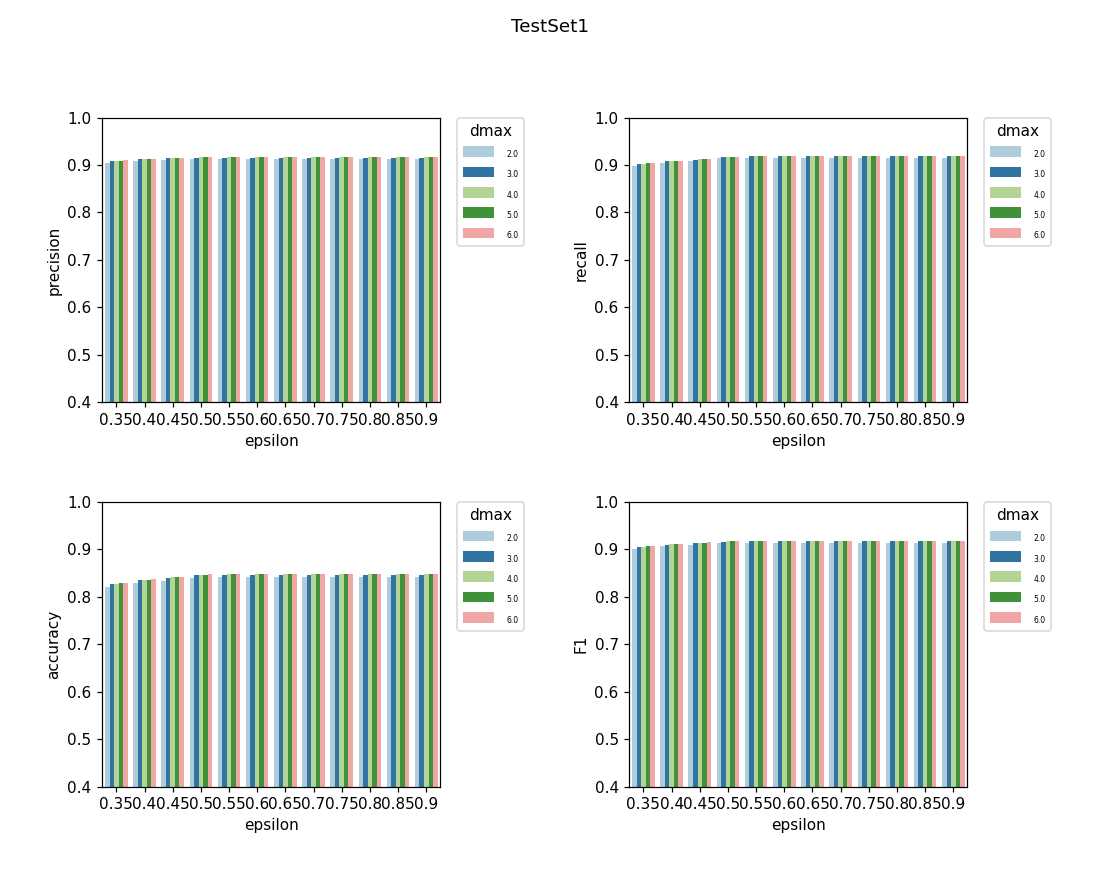

In [31]:
import seaborn as sns
y = [precision, recall, accuracy, F1]
ylabs = ['precision', 'recall', 'accuracy', 'F1']
ax = ['ax1','ax2','ax3','ax4']
fig = plt.figure(figsize=(10,8))
fig.suptitle(f'{TS}')
dmax = np.array(dbscan_params)[:,0]
eps = np.array(dbscan_params)[:,1]
i=0
for i in range(len(ylabs)):
    ax[i] = fig.add_subplot(2,2,i+1)
    ax[i].set(xlabel='epsilon', ylabel=ylabs[i])
    ax[i].set_title('')
    ax[i].set_ylim(0.4,1)
    ax[i] = sns.barplot(x=eps,y=np.array(y[i]),hue=dmax, palette='Paired',ci=None)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="dmax")
    plt.setp(ax[i].get_legend().get_texts(), fontsize='5') 
fig.tight_layout(pad=3.0)
None

<IPython.core.display.Javascript object>


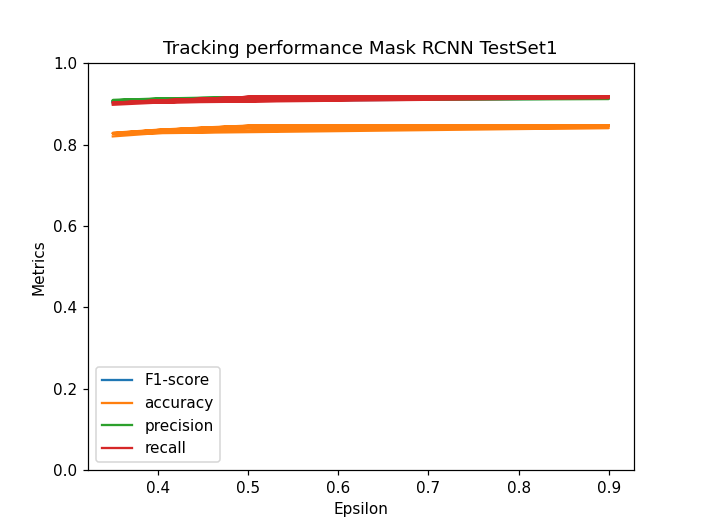

In [32]:
plt.figure()
plt.title(f'Tracking performance Mask RCNN {TS}')
plt.xlabel('Epsilon')
plt.ylabel('Metrics')
plt.plot(eps, F1, label='F1-score')
plt.plot(eps, accuracy, label='accuracy')
plt.plot(eps, precision, label='precision')
plt.plot(eps, recall, label='recall')
plt.ylim(0,1)
plt.legend()

In [33]:
data_track = list(zip(precision,recall,accuracy,F1))
df = pd.DataFrame(data_track, columns=['Precision', 'Recall', 'Accuracy', 'F1-Score'])
df['Epsilon'] = eps
df['Dmax'] = dmax

In [83]:
df.to_csv(f'{TS}_track_metrics_new.csv', index=False)